# Hello!
The goal here is to set up a Convolutional Neural Network to classify Grayscale images.
The idea I set out to accomplish is to complete pipeline to measure performance on a training set and a test set, so that we can refine sections and continue to measure performace of our model before "deployment"

plus notes at the end collected while studying. Note however as you glance throught this, although is a good starting for understanding components of computer vision - but you will notice images are limited in the sense they are 28*28 grayscale and the subject of the images are well centered - this is not relistic of real world images. but the core ideas behind convnets will also be used on much biger well defined images.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import display, Markdown 
from scipy.datasets import ascent
import ipywidgets as widgets

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename)) 

print('') 
 
df_train = pd.read_csv("/kaggle/input/fashionmnist/fashion-mnist_train.csv")
df_test  = pd.read_csv("/kaggle/input/fashionmnist/fashion-mnist_test.csv")

print("Training data shape:", df_train.shape)
print("Test data shape:", df_test.shape)

# 28 * 28 = 784 pixel images + 1 response

/kaggle/input/fashionmnist/t10k-labels-idx1-ubyte
/kaggle/input/fashionmnist/t10k-images-idx3-ubyte
/kaggle/input/fashionmnist/fashion-mnist_test.csv
/kaggle/input/fashionmnist/fashion-mnist_train.csv
/kaggle/input/fashionmnist/train-labels-idx1-ubyte
/kaggle/input/fashionmnist/train-images-idx3-ubyte

Training data shape: (60000, 785)
Test data shape: (10000, 785)


In [2]:
df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
n_images = 10
training_labels = df_train['label'].values[:n_images]
training_images = df_train.drop(columns=['label']).values[:n_images] 
training_images = training_images.reshape(-1, 28, 28)

plot_output = widgets.Output()
with plot_output:
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    axes = axes.flatten()
    for i in range(n_images):
        img = training_images[i]  # Each image is 28x28.
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Label: {training_labels[i]}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()
    
 
table_md = """
<table style="border-collapse: collapse;">
  <tr>
    <th style="border: 1px solid black; padding: 4px;">Label</th>
    <th style="border: 1px solid black; padding: 4px;">Description</th>
  </tr>
  <tr>
    <td style="border: 1px solid black; padding: 4px;">0</td>
    <td style="border: 1px solid black; padding: 4px;">T-shirt/top</td>
  </tr>
  <tr>
    <td style="border: 1px solid black; padding: 4px;">1</td>
    <td style="border: 1px solid black; padding: 4px;">Trouser</td>
  </tr>
  <tr>
    <td style="border: 1px solid black; padding: 4px;">2</td>
    <td style="border: 1px solid black; padding: 4px;">Pullover</td>
  </tr>
  <tr>
    <td style="border: 1px solid black; padding: 4px;">3</td>
    <td style="border: 1px solid black; padding: 4px;">Dress</td>
  </tr>
  <tr>
    <td style="border: 1px solid black; padding: 4px;">4</td>
    <td style="border: 1px solid black; padding: 4px;">Coat</td>
  </tr>
  <tr>
    <td style="border: 1px solid black; padding: 4px;">5</td>
    <td style="border: 1px solid black; padding: 4px;">Sandal</td>
  </tr>
  <tr>
    <td style="border: 1px solid black; padding: 4px;">6</td>
    <td style="border: 1px solid black; padding: 4px;">Shirt</td>
  </tr>
  <tr>
    <td style="border: 1px solid black; padding: 4px;">7</td>
    <td style="border: 1px solid black; padding: 4px;">Sneaker</td>
  </tr>
  <tr>
    <td style="border: 1px solid black; padding: 4px;">8</td>
    <td style="border: 1px solid black; padding: 4px;">Bag</td>
  </tr>
  <tr>
    <td style="border: 1px solid black; padding: 4px;">9</td>
    <td style="border: 1px solid black; padding: 4px;">Ankle boot</td>
  </tr>
</table>
"""
 
table_widget = widgets.HTML(value=table_md, layout=widgets.Layout(margin='35px 0 0 0')) 
display(widgets.HBox([table_widget, plot_output]))


In [4]:
# Image have values from 0-255, but neural networks work better with normalized data. 

# Normalize and reshape training data
training_labels = df_train['label'].values   
training_images = df_train.drop(columns=['label']).values.astype(np.float32) / 255.0
training_images = training_images.reshape(-1, 28, 28)

# Normalize and reshape test data
test_labels = df_test['label'].values  
test_images = df_test.drop(columns=['label']).values.astype(np.float32) / 255.0
test_images = test_images.reshape(-1, 28, 28)

# define the input shape of the data. Then we define the first layer which flattens the input. 
# The output dense layer will have ten units to match the number of classes
# The dense layer in between will try to figure out the rules between the inputs and the outputs.

###################################################################  
# adding more layers wont change much because this is relatively simple data.
# For far more complex data (including color images to be classified as flowers ), extra layers are often necessary.

model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(28,28,1)),
            tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
            tf.keras.layers.MaxPooling2D(2,2),       
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128 , activation = 'relu' ), 
            tf.keras.layers.Dense( 10 , activation = 'softmax' )
])

model.compile(optimizer = tf.optimizers.Adam(), loss = 'sparse_categorical_crossentropy', metrics=['accuracy'] )
model.summary()


###################################################################  

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 243,786 (952.29 KB)

 Trainable params: 243,786 (952.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 47s 30ms/step - accuracy: 0.7672 - loss: 0.6427 - val_accuracy: 0.8842 - val_loss: 0.3360
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 81s 30ms/step - accuracy: 0.8791 - loss: 0.3218 - val_accuracy: 0.8946 - val_loss: 0.2941
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 44s 30ms/step - accuracy: 0.9030 - loss: 0.2635 - val_accuracy: 0.9032 - val_loss: 0.2699
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 47s 31ms/step - accuracy: 0.9149 - loss: 0.2277 - val_accuracy: 0.8999 - val_loss: 0.2667
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 44s 29ms/step - accuracy: 0.9249 - loss: 0.1969 - val_accuracy: 0.9096 - val_loss: 0.2541
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 44s 30ms/step - accuracy: 0.9366 - loss: 0.1727 - val_accuracy: 0.9103 - val_loss: 0.2509
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 44s 29ms/step - accuracy: 0.9440 - loss: 0.1512 - val_accuracy: 0.9022 - val_loss: 0.2716
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 44s 29ms/step - accuracy: 0.9506 -

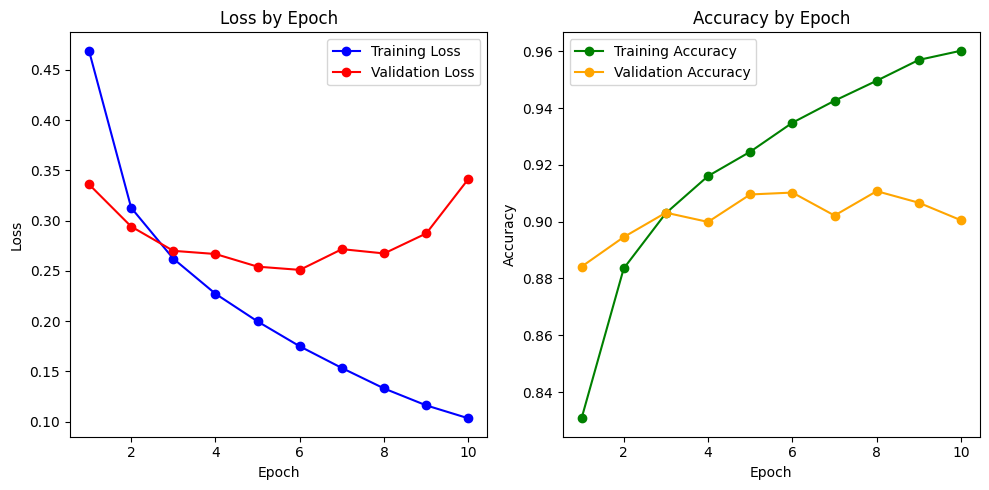

In [5]:
# calback to stop on a validation 
# In practice, it’s often better to monitor a validation metric 
# (such as validation loss or validation accuracy) for early stopping rather than training accuracy. 
# The validation metric provides a better indication of the model’s generalization performance, 
# so stopping based on it helps ensure that training does not cease before the model has properly learned to generalize.

class MyValidationCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None): 
        if logs.get('val_accuracy') is not None and logs.get('val_accuracy') >= 0.9:
            print("\nReached 90% validation accuracy, stopping training!")
            self.model.stop_training = True

# callbacks = [MyValidationCallback()]

##################################################################

# Training the model and capturing the training history
history = model.fit(training_images, training_labels, validation_split = .2 , epochs = 10 )
epochs_range = range(1, len(history.history['loss']) + 1)
 
print("Performance on test data (unseen):")
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
 
###################################################################  

plt.figure(figsize=(10, 5)) 
# Plot Loss: Training vs. Validation
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['loss'], marker='o', color='blue', label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], marker='o', color='red', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss by Epoch')
plt.legend()

# Plot Accuracy: Training vs. Validation
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['accuracy'], marker='o', color='green', label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], marker='o', color='orange', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy by Epoch')
plt.legend()

plt.tight_layout()
plt.show()




* Lets study missclassifications
  

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
Total test samples: 10000
Correct predictions: 9046
Wrong predictions: 954
Test Accuracy: 90.46%

Number of incorrect predictions: 954


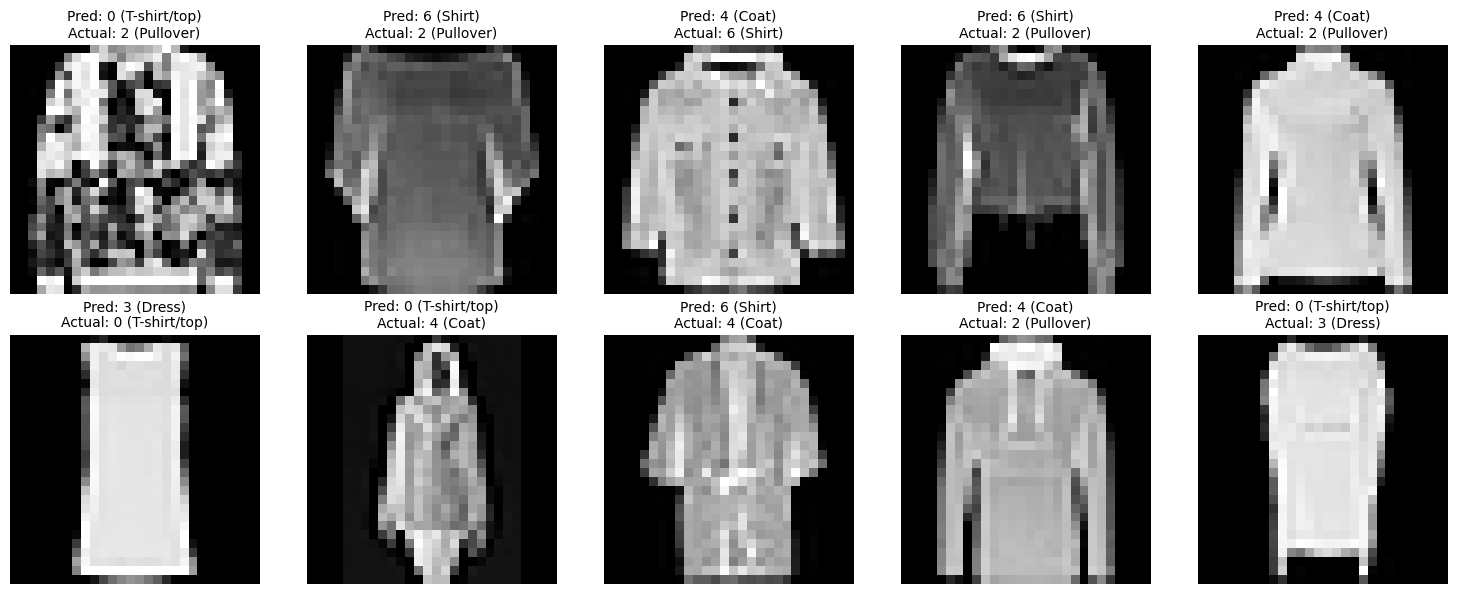

In [6]:
classifications = model.predict(test_images)

predicted_labels = np.argmax(classifications, axis=1)

correct_predictions = (predicted_labels == test_labels)
n_correct = np.sum(correct_predictions)
n_total = len(test_labels)
n_wrong = n_total - n_correct
accuracy = n_correct / n_total
 
print("Total test samples:", n_total)
print("Correct predictions:", n_correct)
print("Wrong predictions:", n_wrong)
print("Test Accuracy: {:.2f}%".format(accuracy * 100))
print('')

########################################################################################
 
# Define the dictionary mapping label indices to descriptions.
label_descriptions = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}
 
incorrect_indices = np.where(predicted_labels != test_labels)[0]
print("Number of incorrect predictions:", len(incorrect_indices))
 
n_to_display = min(10, len(incorrect_indices))
selected_indices = incorrect_indices[:n_to_display]
 
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
 
for i, idx in enumerate(selected_indices):
    img = test_images[idx]   
    pred = predicted_labels[idx]
    actual = test_labels[idx] 
    title = f"Pred: {pred} ({label_descriptions[pred]})\nActual: {actual} ({label_descriptions[actual]})"
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(title, fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.show()



# Notes on Convolutions + Max Pooling

# Visualizing Convolution and Pooling Layer Activations

This code is designed to graphically show how an input image is transformed as it passes through certain layers of a trained model (specifically, convolutional and max pooling layers).

## Step-by-Step Explanation

1. **Printing Labels and Identifying Examples**
    ```python
    print(f"First 100 labels:\n\n{test_labels[:100]}")
    print(f"\nShoes: {[i for i in range(100) if test_labels[:100][i]==9]}")
    ```
    - **What It Does:**  
      Prints the first 100 labels from the test set. Then, it prints the indices of the images (within the first 100) whose label is 9.  
    - **Why It Matters:**  
      This helps identify specific examples (e.g., images of shoes, if label 9 corresponds to shoes) that you might want to inspect more closely.

2. **Choosing Images and Convolution Channel**
    ```python
    FIRST_IMAGE = 0
    SECOND_IMAGE = 23
    THIRD_IMAGE = 28
    CONVOLUTION_NUMBER = 1
    ```
    - **What It Does:**  
      Sets the indices for three different test images you want to visualize. The variable `CONVOLUTION_NUMBER` specifies which feature map (i.e., channel) to display from each layer’s output.
    - **Why It Matters:**  
      By selecting specific images and a particular channel, you can see how a specific filter responds to different inputs.

3. **Selecting Layers to Visualize**
    ```python
    layers_to_visualize = [tf.keras.layers.Conv2D, tf.keras.layers.MaxPooling2D]
    layer_outputs = [layer.output for layer in model.layers if type(layer) in layers_to_visualize]
    ```
    - **What It Does:**  
      - `layers_to_visualize` defines the types of layers (Conv2D and MaxPooling2D) that you are interested in.
      - The list comprehension loops over all layers in the model and collects the output tensors for those that are of the specified types.
    - **Why It Matters:**  
      This allows you to inspect the activations from the convolution and pooling layers, which are responsible for feature extraction and down-sampling.

4. **Creating an Activation Model**
    ```python
    activation_model = tf.keras.models.Model(inputs=model.inputs, outputs=layer_outputs)
    ```
    - **What It Does:**  
      Creates a new Keras model that takes the same inputs as your original model but outputs the activations of the selected layers.
    - **Why It Matters:**  
      This model lets you easily compute and extract the intermediate outputs (activations) for any input image.

5. **Setting Up the Plotting Grid**
    ```python
    f, axarr = plt.subplots(3, len(layer_outputs))
    ```
    - **What It Does:**  
      Creates a grid of subplots with 3 rows (one per chosen image) and a number of columns equal to the number of layers you are visualizing.
    - **Why It Matters:**  
      It organizes the plots so you can compare how each selected layer transforms each image side by side.

6. **Looping Through Layers and Images to Visualize Activations**
    ```python
    for x in range(len(layer_outputs)):
        # For the first image
        f1 = activation_model.predict(test_images[FIRST_IMAGE].reshape(1, 28, 28, 1), verbose=False)[x]
        axarr[0, x].imshow(f1[0, :, :, CONVOLUTION_NUMBER], cmap='inferno')
        axarr[0, x].grid(False)
      
        # For the second image
        f2 = activation_model.predict(test_images[SECOND_IMAGE].reshape(1, 28, 28, 1), verbose=False)[x]
        axarr[1, x].imshow(f2[0, :, :, CONVOLUTION_NUMBER], cmap='inferno')
        axarr[1, x].grid(False)
      
        # For the third image
        f3 = activation_model.predict(test_images[THIRD_IMAGE].reshape(1, 28, 28, 1), verbose=False)[x]
        axarr[2, x].imshow(f3[0, :, :, CONVOLUTION_NUMBER], cmap='inferno')
        axarr[2, x].grid(False)
    ```
    - **What It Does:**  
      - **For Each Layer (each column):**
        - The code uses the `activation_model` to predict the activations for a given test image.  
        - Each test image is reshaped to add a batch dimension (i.e., from `(28, 28, 1)` to `(1, 28, 28, 1)`).
        - The activation for the selected layer (`[x]` in the list of outputs) is then extracted.
        - From the activation tensor, the code selects the feature map corresponding to `CONVOLUTION_NUMBER` (i.e., the second channel) and displays it using the `inferno` colormap.
      - **Why It Matters:**  
        This loop visually demonstrates how different layers (both convolution and pooling) process the input images. By examining the feature maps, you can gain insight into what features the network is extracting at each stage.

## Summary

- **Printing Labels:** Helps identify specific examples (e.g., images labeled as shoes).
- **Selecting Images and Channels:** Determines which images and which filter responses to visualize.
- **Choosing Layers:** Focuses on convolutional and pooling layers to show feature extraction.
- **Activation Model:** A special model that outputs intermediate layer activations.
- **Plotting:** Arranges the results in a grid for easy comparison of how each image is transformed by each layer.

This visualization is a powerful tool for understanding the inner workings of your neural network model.


First 100 labels:

[0 1 2 2 3 2 8 6 5 0 3 4 4 6 8 5 6 3 6 4 4 4 2 1 5 7 8 4 4 1 5 7 7 8 1 0 9
 8 0 8 2 0 4 6 2 0 3 3 2 3 2 2 9 3 0 9 9 4 6 0 4 5 4 6 1 1 0 9 5 2 7 3 4 6
 5 7 1 6 1 4 9 8 1 2 4 8 9 4 1 6 3 4 2 2 2 6 4 7 7 3]

Shoes: [36, 52, 55, 56, 67, 80, 86]


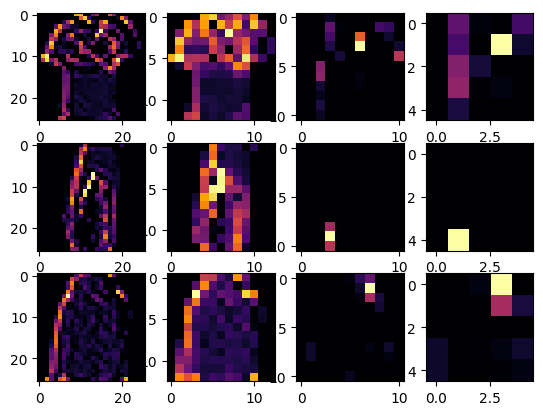

In [7]:
# Code to show effects of convolution graphically 

print(f"First 100 labels:\n\n{test_labels[:100]}")

print(f"\nShoes: {[i for i in range(100) if test_labels[:100][i]==9]}")

FIRST_IMAGE=0
SECOND_IMAGE=23
THIRD_IMAGE=28
CONVOLUTION_NUMBER = 1
layers_to_visualize = [tf.keras.layers.Conv2D, tf.keras.layers.MaxPooling2D]

layer_outputs = [layer.output for layer in model.layers if type(layer) in layers_to_visualize]
activation_model = tf.keras.models.Model(inputs = model.inputs, outputs=layer_outputs)

f, axarr = plt.subplots(3,len(layer_outputs))

for x in range(len(layer_outputs)):
    f1 = activation_model.predict(test_images[FIRST_IMAGE].reshape(1, 28, 28, 1), verbose=False)[x]
    axarr[0,x].imshow(f1[0, :, :, CONVOLUTION_NUMBER], cmap='inferno')
    axarr[0,x].grid(False)
  
    f2 = activation_model.predict(test_images[SECOND_IMAGE].reshape(1, 28, 28, 1), verbose=False)[x]
    axarr[1,x].imshow(f2[0, :, :, CONVOLUTION_NUMBER], cmap='inferno')
    axarr[1,x].grid(False)
  
    f3 = activation_model.predict(test_images[THIRD_IMAGE].reshape(1, 28, 28, 1), verbose=False)[x]
    axarr[2,x].imshow(f3[0, :, :, CONVOLUTION_NUMBER], cmap='inferno')
    axarr[2,x].grid(False)

# Understanding Filter Normalization in Convolutional Layers

When designing a convolution filter (or kernel) for image processing, the sum of the filter’s elements (the weights) plays an important role in the filter's behavior. The comments in your code refer to normalizing the filter so that its overall effect is as intended. Let's break this down:

## What Do Filter Sums Mean?

### 1. Preserving Brightness
- **Goal:**  
  For filters used in smoothing or blurring, you want the overall brightness (or intensity) of the image to remain unchanged after applying the filter.
- **How It Works:**  
  To achieve this, the sum of all the filter elements should be **1**. When the filter is applied (as a weighted average), the output pixel's intensity remains properly scaled.
- **Example:**  
  Consider the filter:
  ```python
  [[1, 1, 1],
   [1, 2, 1],
   [1, 1, 1]]
  ```  
  The sum is:  
  \(1 + 1 + 1 + 1 + 2 + 1 + 1 + 1 + 1 = 10\).  
  To normalize the filter so that the sum is 1, multiply each element by \(\frac{1}{10} = 0.1\).  
  After normalization, the filter becomes:
  ```python
  [[0.1, 0.1, 0.1],
   [0.1, 0.2, 0.1],
   [0.1, 0.1, 0.1]]
  ```
  This ensures that the overall brightness of the image isn't unintentionally altered.

### 2. Edge Detection (Sum to 0)
- **Goal:**  
  Some filters, particularly those used for edge detection (like Laplacian filters), are designed to have a sum of **0**.
- **How It Works:**  
  A sum of 0 means that uniform regions (with little or no change in pixel values) will result in an output of 0, highlighting only areas with significant changes (edges).
- **Example:**  
  Consider this filter:
  ```python
  [[ 0,  1,  0],
   [ 1, -4,  1],
   [ 0,  1,  0]]
  ```  
  The sum is:
  \(0 + 1 + 0 + 1 - 4 + 1 + 0 + 1 + 0 = 0\),  
  so it is already set up for edge detection.

## What Does the Weight Do?

The code snippet includes a comment and a weight variable:

```python
# If all the digits in the filter don't add up to 0 or 1, you 
# should probably do a weight to get it to do so
# so, for example, if your weights are 1,1,1 1,2,1 1,1,1
# They add up to 10, so you would set a weight of .1 if you want to normalize them
weight = 1
```

- **When the Filter Sum Is Not Ideal:**  
  If your filter’s weights do not sum to 1 (for brightness preservation) or 0 (for edge detection), you can apply a multiplicative normalization factor (here called `weight`) to adjust the sum.

- **Normalization Example:**  
  For the filter:
  ```python
  [[1, 1, 1],
   [1, 2, 1],
   [1, 1, 1]]
  ```  
  The sum is 10. To ensure that the filter preserves the image brightness, you’d multiply every element by 0.1 (`weight = 0.1`), making the sum \(10 \times 0.1 = 1\).

- **When `weight = 1`:**  
  Setting `weight = 1` means no scaling is applied. This is appropriate when the filter’s weights already sum to the desired value (either 0 for edge detection or 1 for brightness preservation).

## Summary

- **Normalization Purpose:**  
  Adjusting the filter with a weight (or scaling factor) ensures that the filter produces the intended effect on the image.
  
- **Choosing the Correct Weight:**  
  - **For Smoothing/Blurring:**  
    The filter's elements should sum to **1**.
  - **For Edge Detection:**  
    The filter's elements should sum to **0**.
  - If the raw filter values don’t meet these criteria, apply a normalization weight (e.g., multiply by 0.1 if the sum is 10 but you want a sum of 1).

- **In Your Code:**  
  The variable `weight = 1` indicates that no scaling is needed because the filter already has the desired sum, or the operation doesn't require scaling.

Normalization is a common practice in image processing and convolutional neural networks (CNNs) to ensure that filters behave as expected during convolution.


<ipython-input-8-1917fa2b3a1e>:8: DeprecationWarning: scipy.misc.ascent has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.ascent instead.
  ascent_image = ascent()  # Load the sample image


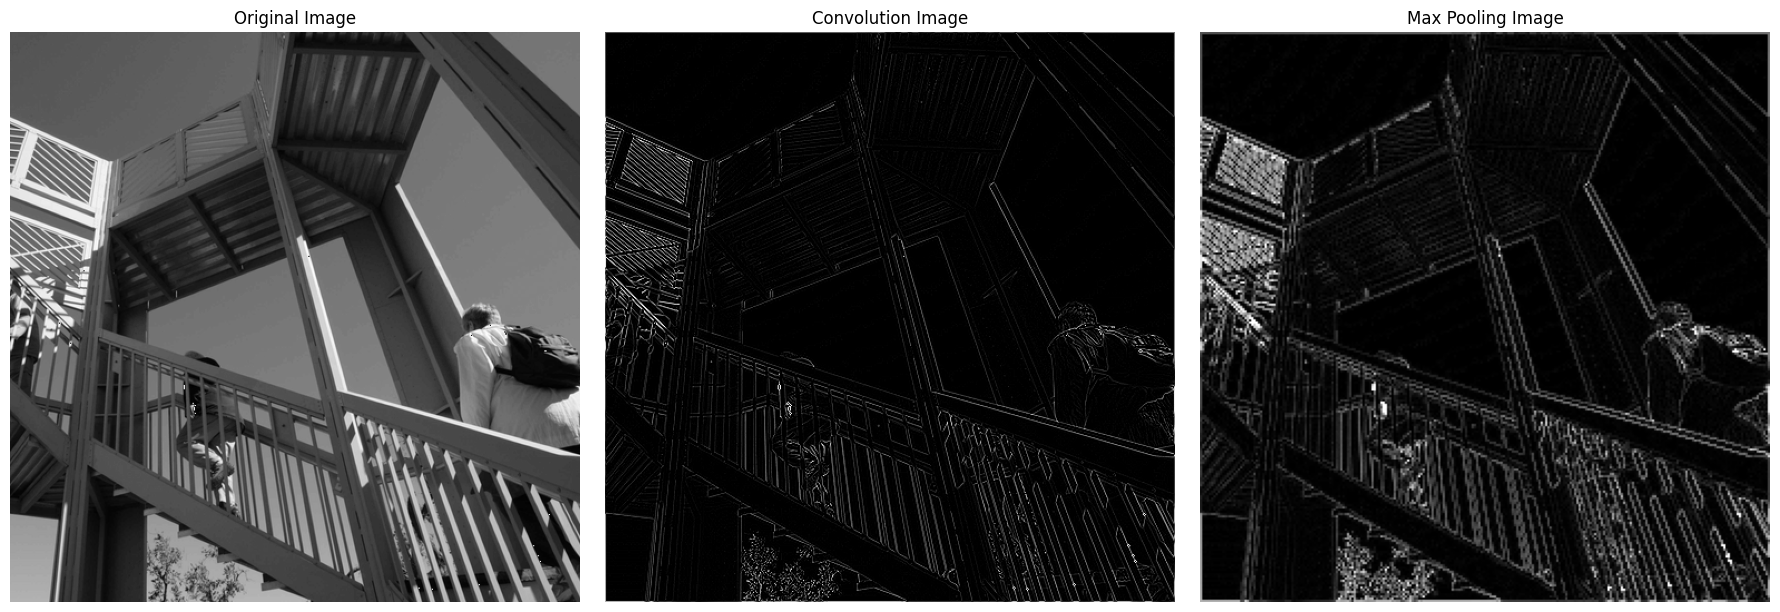

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import ascent  # For loading the sample Ascent image

# -----------------------------
# 1. Load the Original Image
# -----------------------------
ascent_image = ascent()  # Load the sample image
size_x, size_y = ascent_image.shape  # Get image dimensions

# -----------------------------
# 2. Apply a Convolution Filter
# -----------------------------
# Make a copy to store the convolution result
image_transformed = np.copy(ascent_image)

# Define the convolution filter and weight
# (This filter is an edge-detection filter with sum=0)
filter_kernel = [[0, 1, 0], [1, -4, 1], [0, 1, 0]]
weight = 1  # No normalization needed here as the filter sums to 0

# Apply the convolution operation (skip border pixels)
for x in range(1, size_x - 1):
    for y in range(1, size_y - 1):
        # Compute the convolution sum over the 3x3 neighborhood
        convolution = (
            ascent_image[x-1, y-1] * filter_kernel[0][0] +
            ascent_image[x-1, y  ] * filter_kernel[0][1] +
            ascent_image[x-1, y+1] * filter_kernel[0][2] +
            ascent_image[x,   y-1] * filter_kernel[1][0] +
            ascent_image[x,   y  ] * filter_kernel[1][1] +
            ascent_image[x,   y+1] * filter_kernel[1][2] +
            ascent_image[x+1, y-1] * filter_kernel[2][0] +
            ascent_image[x+1, y  ] * filter_kernel[2][1] +
            ascent_image[x+1, y+1] * filter_kernel[2][2]
        )
        # Multiply by weight
        convolution *= weight
        # Clamp the result to the [0, 255] range
        convolution = np.clip(convolution, 0, 255)
        image_transformed[x, y] = convolution

# -----------------------------
# 3. Apply Max Pooling
# -----------------------------
# Define new dimensions: half the original size
new_x = size_x // 2
new_y = size_y // 2
newImage = np.zeros((new_x, new_y))

# For each 2x2 block in the transformed image, take the max value
for x in range(0, size_x - 1, 2):
    for y in range(0, size_y - 1, 2):
        # Collect the four pixels from the 2x2 block
        pixels = [
            image_transformed[x, y],
            image_transformed[x+1, y],
            image_transformed[x, y+1],
            image_transformed[x+1, y+1]
        ]
        newImage[x // 2, y // 2] = max(pixels)

# -----------------------------
# 4. Plot All Three Images Side by Side
# -----------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original Image
axes[0].imshow(ascent_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Convolution Image
axes[1].imshow(image_transformed, cmap='gray')
axes[1].set_title('Convolution Image')
axes[1].axis('off')

# Max Pooling Image
axes[2].imshow(newImage, cmap='gray')
axes[2].set_title('Max Pooling Image')
axes[2].axis('off')

plt.tight_layout()
plt.show()
